In [1]:
%pylab inline --no-import-all

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
import george
from george.kernels import MyDijetKernelSimp

import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt

In [3]:
runOnlyGP=False
runOnlyFF=False

### Load all inputs

In [58]:
#Full bin centers (xvalO), counts (yvalO), bin width (xerrO), and bin low edges (xlowO) from ATLAS
xvalO = np.load("outputs/xvalO.npy")
yvalO = np.load("outputs/yvalO.npy")
xerrO = np.load("outputs/xerrO.npy")
xlowO = np.load("outputs/xlowO.npy")

#Same, but with bins with zero counts removed. GP fits better without zero counts
xval = np.load("outputs/xval.npy")
yval = np.load("outputs/yval.npy")
xerr = np.load("outputs/xerr.npy")

#10000 toys - created from 5 parameter fit to data with Poisson noise
toyList = np.load("outputs/toyList.npy")

#hyperparameters (kernel and mean) from GP fit to ATLAS data.
fixedHyperparams = np.load("outputs/fixedHyperparams.npy")

#fixedHyperparams = [7659865665513.668, 16.409143717593864, 860.5123775887412, 1318.7820614583816, 1787.204493869843, 0.010408004540440885, 7.739988389242991, -5.3965991996830525]
#Gaussian signal parameters (amplitude, mean, and width) for different masses
#standardParamSets = [(1500,2000,250), (750 ,2500, 250), (200, 3000, 250), (75, 3500, 250), (50, 4000, 250), 
#             (25, 4500, 250), (20, 5000, 250), (15,5500, 250), (15, 6000,250)]
#10000 Gaussian signals at each mass point with Poisson noise at bin xval (zero bins removed)
#sigToys = np.load("savedOutputs/signalToys.npy")
#10000 Gaussian signals at each mass point with Poisson noise at bins xvalO (original ATLAS binning)
#sigToysO = np.load("savedOutputs/signalToysO.npy")

'''
sigToys = np.load("savedOutputs/signalToys.npy")
sigToysO = np.load("savedOutputs/signalToysO.npy")
standardParamSets = [(2000,2000,250), (700, 2500, 250)]#, (250, 3000, 250), (125, 3500, 250), (70, 4000, 250), 
             #(40, 4500, 250), (25, 5000, 250), (15,5500, 250), (10, 6000,250)]
'''
sigToys = np.load("savedOutputs/signalToys_high.npy")
sigToysO = np.load("savedOutputs/signalToysO_high.npy")
standardParamSets = [(1200,2000,250), (500, 2500, 250), (500, 3000, 250), (400, 3500, 250), (100, 4000, 250), 
             (75, 4500, 250), (60, 5000, 250), (50,5500, 250), (50, 6000,250)]


[  1.27588479e+08   3.13928191e+01   5.67575382e-01   2.63727741e+01
   8.09797457e+02   1.66130591e-02   8.46330865e+00  -5.22253515e+00]


#### Gaussian signal function

In [5]:
def sig_model(x, N=1e5, mass=2000., width=100., xErr=xerr):
    return N*(np.exp(-(x-mass)**2/2/width/width)/np.sqrt(2*np.pi)/width)*xErr

#### 3 and 5 parameter fit functions

In [6]:
def model_3param(t, params, xErr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2))*(xErr)  
def model_5param(t, params, xErr=xerr): 
    p0, p1, p2, p3, p4 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2+p3*np.log(t/sqrts)+p4*np.log(t/sqrts)**2))*(xErr)

#### Calculate z value and chi squared

In [7]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2

#### Poisson log likelihood

In [8]:
def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson

In [9]:
def simpleLogPoisson_nogamma(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par 
        return lnpoisson
    

def logLike_gpLikeFF_nogamma(y1, y2):
    logL = 0
    for ibin in range(len(y1)):
        data = y1[ibin]
        bkg = y2[ibin]
        logL += -simpleLogPoisson_nogamma(data, bkg)
    try:
        logL
        return logL
    except:
        return np.inf  

class logLike_3ff_nogamma:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2):
        params = p0, p1, p2
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin]
            logL += -simpleLogPoisson_nogamma(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    
class logLike_3ff_sig_nogamma:
    def __init__(self, x, y, xe, sigTemp):
        self.x = x
        self.y = y
        self.xe = xe
        self.sigTemp = sigTemp
    def __call__(self, p0, p1, p2, N):
        params = p0, p1, p2
        nSignal = N
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        sig=0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            sig = self.sigTemp[ibin]*nSignal
            logL += -simpleLogPoisson_nogamma(data, bkg+sig)
        try:
            logL
            return logL
        except:
            return np.inf
        
class logLike_5ff_nogamma:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2, p3, p4):
        params = p0, p1, p2, p3, p4
        bkgFunc = model_5param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            logL += -simpleLogPoisson_nogamma(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    
class logLike_5ff_sig_nogamma:
    def __init__(self, x, y, xe, sigTemp):
        self.x = x
        self.y = y
        self.xe = xe
        self.sigTemp = sigTemp
    def __call__(self, p0, p1, p2, p3, p4, N):
        params = p0, p1, p2, p3, p4
        nSignal = N
        bkgFunc = model_5param(self.x, params, self.xe)       
        logL = 0
        sig=0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            sig = self.sigTemp[ibin]*nSignal
            logL += -simpleLogPoisson_nogamma(data, bkg+sig)
        try:
            logL
            return logL
        except:
            return np.inf

In [10]:
def simpleGaussian(d, b):
    if d < 0: 
        return np.inf
    elif d == 0: return 0
    else:
        lnGaus = 0.5*((d-b)/np.sqrt(d))**2
        return lnGaus
    
def logLike_gpLikeFF_gaus(y1, y2):
    logL = 0
    for ibin in range(len(y1)):
        data = y1[ibin]
        bkg = y2[ibin]
        logL += simpleGaussian(data, bkg)
    try:
        logL
        return logL
    except:
        return np.inf  

class logLike_3ff_gaus:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2):
        params = p0, p1, p2
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin]
            logL += simpleGaussian(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    
class logLike_3ff_sig_gaus:
    def __init__(self, x, y, xe, sigTemp):
        self.x = x
        self.y = y
        self.xe = xe
        self.sigTemp = sigTemp
    def __call__(self, p0, p1, p2, N):
        params = p0, p1, p2
        nSignal = N
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        sig=0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            sig = self.sigTemp[ibin]*nSignal
            logL += simpleGaussian(data, bkg+sig)
        try:
            logL
            return logL
        except:
            return np.inf
        
class logLike_5ff_gaus:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2, p3, p4):
        params = p0, p1, p2, p3, p4
        bkgFunc = model_5param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            logL += simpleGaussian(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    
class logLike_5ff_sig_gaus:
    def __init__(self, x, y, xe, sigTemp):
        self.x = x
        self.y = y
        self.xe = xe
        self.sigTemp = sigTemp
    def __call__(self, p0, p1, p2, p3, p4, N):
        params = p0, p1, p2, p3, p4
        nSignal = N
        bkgFunc = model_5param(self.x, params, self.xe)       
        logL = 0
        sig=0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            sig = self.sigTemp[ibin]*nSignal
            logL += simpleGaussian(data, bkg+sig)
        try:
            logL
            return logL
        except:
            return np.inf   
    



#### remove zero count bins - makes GP smoother 

In [11]:
def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

#### Plot distribution of log likelihood ratio with chi2 drawn on top

In [12]:
def makePrettyPlots_LLH(GP_LLH, FF_LLH, title, drawchi2=False, xname=r'$\chi^{2}$', label1 = "Gaussian Process", label2 = "Fit Function"):
    f, (ax1, ax2) = plt.subplots(2, figsize=(12,12), gridspec_kw = {'height_ratios':[1, 1]})
    f.suptitle(title, fontsize=30)

    lowx = min(min(GP_LLH), min(FF_LLH))
    #highx = max(max(GP_LLH), max(FF_LLH))
    #lowx = 0.01
    highx = 10

    
    bins = np.linspace(lowx, highx, 200)
    dx = bins[1]-bins[0]
    bin_centers = bins[:-1] + dx/2.
    hGP, _, _ =ax1.hist(GP_LLH, bins=bins, color="b")
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax1.set_title(label1, fontsize=20)
    if drawchi2:
        chi2_gp =sum(hGP)*(bins[1]-bins[0])*ss.chi2.pdf(bin_centers, 1.)
        ax1.plot(bin_centers, chi2_gp, c='r', linewidth=2)
    
    
    hFF, _, _ =ax2.hist(FF_LLH, bins=bins, color='g')
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.set_xlabel(xname, fontsize=30)
    ax2.set_title(label2, fontsize=20)
    if drawchi2:
        chi2_ff = sum(hFF)*(bins[1]-bins[0])*ss.chi2.pdf(bin_centers, 1.) 
        ax2.plot(bin_centers, chi2_ff, c='r', linewidth=2)



    plt.show()




#### Poisson log likelihoods for Gaussian Process, 3 parameter fit function, 3 parameter fit function with signal strength parameter, 5 parameter fit function, and 5 parameter fit function with signal strength parameter. Goes into minuit to minimize

In [13]:
def logLike_gpLikeFF(y1, y2):
    logL = 0
    for ibin in range(len(y1)):
        data = y1[ibin]
        bkg = y2[ibin]
        logL += -simpleLogPoisson(data, bkg)
    try:
        logL
        return logL
    except:
        return np.inf  

class logLike_3ff:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2):
        params = p0, p1, p2
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin]
            logL += -simpleLogPoisson(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    

    
class logLike_3ff_sig:
    def __init__(self, x, y, xe, sigTemp):
        self.x = x
        self.y = y
        self.xe = xe
        self.sigTemp = sigTemp
    def __call__(self, p0, p1, p2, N):
        params = p0, p1, p2
        nSignal = N
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        sig=0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            sig = self.sigTemp[ibin]*nSignal
            logL += -simpleLogPoisson(data, bkg+sig)
        try:
            logL
            return logL
        except:
            return np.inf
        
class logLike_5ff:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2, p3, p4):
        params = p0, p1, p2, p3, p4
        bkgFunc = model_5param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            logL += -simpleLogPoisson(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    
class logLike_5ff_sig:
    def __init__(self, x, y, xe, sigTemp):
        self.x = x
        self.y = y
        self.xe = xe
        self.sigTemp = sigTemp
    def __call__(self, p0, p1, p2, p3, p4, N):
        params = p0, p1, p2, p3, p4
        nSignal = N
        bkgFunc = model_5param(self.x, params, self.xe)       
        logL = 0
        sig=0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            sig = self.sigTemp[ibin]*nSignal
            logL += -simpleLogPoisson(data, bkg+sig)
        try:
            logL
            return logL
        except:
            return np.inf

#### Minuit minimization of 3 parameter fit function, 3 parameter fit function + signal, 5 parameter fit function, and 5 parameter fit function with signal

In [14]:
def fit_3ff(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 10:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * -6.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  p0 = init0, p1 = init1, p2 = init2,
                  error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, 
                  limit_p0 = (0, 20.), limit_p1 = (-20., 20.), limit_p2 = (-20., 20.))

        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 9: 
            print "retry number = ", 10, ": failed fits", lnprob.__class__.__name__
            minLLH=np.inf
            best_fit_params=(0, 0, 0)
        numRetries+=1

    if Print:
        print "min LL", minLLH
        print "best fit vals", best_fit_params
    return minLLH, best_fit_params

def fit_3ff_sig(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0., 0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 15:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * -6.
        init3 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  p0 = init0, p1 = init1, p2 = init2, N = init3,
                  error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, error_N = 1e-4,
                  limit_p0 = (0, 20.), limit_p1 = (-20., 20.), limit_p2 = (-20., 20.), limit_N = (0, 100))
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 14: 
            print "retry number = ", 15, ": failed fits", lnprob.__class__.__name__
            minLLH=np.inf
            best_fit_params=(0, 0, 0, 0)
        numRetries+=1
    if Print:
        print "min LL", minLLH
        print "best fit vals",best_fit_params
    return minLLH, best_fit_params

def fit_5ff(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0., 0., 0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 10:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * -6.
        init3 = np.random.random() * 1.
        init4 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  p0 = init0, p1 = init1, p2 = init2, p3 = init3, p4 = init4,
                  error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, error_p3 = 1e-2, error_p4 = 1e-2,
                  limit_p0 = (0, 10), limit_p1 = (-20, 20), limit_p2 = (-20, 20), 
                   limit_p3 = (-10, 10), limit_p4 = (-20, 20))
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 9: 
            print "retry number = ", 10, ": failed fits", lnprob.__class__.__name__
            minLLH=np.inf
            best_fit_params=(0, 0, 0, 0, 0)
        numRetries+=1
    if Print:
        print "min LL", minLLH
        print "best fit vals", best_fit_params
    return minLLH, best_fit_params

def fit_5ff_sig(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0., 0., 0., 0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 15:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * -6.
        init3 = np.random.random() * 1.
        init4 = np.random.random() * 1.
        init5 = np.random.random() * 1
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  p0 = init0, p1 = init1, p2 = init2, p3 = init3, p4 = init4, N = init5,
                  error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, error_p3 = 1e-2, error_p4 = 1e-2, error_N = 1e-4,
                  limit_p0 = (0, 10), limit_p1 = (-20, 20), limit_p2 = (-20, 20), 
                   limit_p3 = (-10, 10), limit_p4 = (-20, 20), limit_N = (0, 100))
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 14: 
            print "retry number = ", 15, ": failed fits", lnprob.__class__.__name__
            minLLH=np.inf
            best_fit_params=(0, 0, 0, 0, 0, 0)
        numRetries+=1
    if Print:
        print "min LL", minLLH
        print "best fit vals",best_fit_params
    return minLLH, best_fit_params

#### Gaussian Process fit. model_gp is 3 parameter fit function used as mean. log likelihood calculation from george where kernel and mean parameters are fixed and only signal strength parameter is fit. Fit using minuit

In [44]:
def model_gp(params, t, xerr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

class logLike_gp_tempSig_fixedH:
    def __init__(self, x, y, xerr, sigTemp):
        self.x = x
        self.y = y
        self.xerr = xerr
        self.sigTemp = sigTemp
    def __call__(self, N):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr)-N*self.sigTemp)
        except:
            return np.inf        
        
def fit_gp_tempSig_fixedH_minuit(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, 
                   N = init0, error_N = 1e-4, limit_N = (0, 100)) 
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            minLLH=np.inf
            best_fit_params=(0)
        numRetries+=1
    if Print:
        print "min LL", minLLH
        print "best fit vals",best_fit_params
    return minLLH, best_fit_params




In [36]:
def makePrettyPlots(xs, ys, bkgs, title, col = 'g', ymax = 2e5):
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data+signal")
    bkgPlot, =ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="bkg only")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 9500])
    ax1.set_ylim([0.1, ymax])
  
    #bin by bin significance    
    zvals, chi2 = calcSignificance(ys, bkgs)
    print "chi2", chi2
    h1 = Hist(list(xlowO),markersize=0)
    for x in range(len(zvals)):
        if zvals[x] == np.inf or zvals[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals[x]  

    h1.fillstyle = 'solid'
    if col == 'g':
         h1.fillcolor = 'green'
    elif col == 'b':
         h1.fillcolor = 'blue'
    elif col == 'r':
         h1.fillcolor = 'red'
    else:
        h1.fillcolor = 'black'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    rplt.bar(h1, xerr=None, yerr=None)
    ax2.axhline(0, color='black', lw=1)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_xscale('log')
    ax2.set_xlim([1000, 9500])
    ax2.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 9500, 100)
    ax2.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7", "8","9"]
    ax2.set_xticklabels(labels)
    ax2.set_ylim([-5, 5])
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

###  Background and signal+background fit on background toys only. To run over enough toys to get a good chi2 fit, only run on one signal mass point. Loop over 5000 toys and fit just background and background + a 3.5 TeV Gaussian signal. Background only prediction with fixed hyperparameters and mean parameters is in first part; fitting with minuit the signal strength for a signal + background prediction is in the second part. Calculate a log likehood ratio using george and using a Poisson likelihood.

In [59]:
if runOnlyFF: pass
else: 
    btime=time.time()

    LLlistGP={}
    LLlistGPP={}
  #  LLlistGPG={}
  #  LLlistGPng={}
    for pSet in standardParamSets:
        n, m, w = pSet
        print pSet
        LLlistGP[m]=[]
        LLlistGPP[m]=[]
        #LLlistGPG[m]=[]
        #LLlistGPng[m]=[]
        
        for itoy, toy in enumerate(toyList[:1000]):
            if not itoy%500: 
                #np.save("LLH_GP", LLlistGP_b)
                print itoy
            ytoy, xtoy, xtoyerr = removeZeros(toy)
            signalTemplate = sigToys[()][m][itoy]
            ydata = ytoy

            signalTemplateO = sigToysO[()][m][itoy]
            ydataO = toy

            #BACKGROUND ONLY FIT GP
            if not itoy%500:
                pgpb_stime = time.time()
            Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
            kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
            gp1 = george.GP(kernel1)
            gp1.compute(xtoy, np.sqrt(ydata))
            MAP1p, covGP1 = gp1.predict(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
            MAP1 = MAP1p+ model_3param(xvalO,(p0,p1,p2),xerrO)
            gpLLH = gp1.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr))
            if not itoy%500:
                pgpb_etime = time.time()
                print "background only time:", pgpb_etime-pgpb_stime

            #if not itoy%100: 
            #    makePrettyPlots(xvalO, ydataO, MAP1, "", col = 'g', ymax = 2e5)
                
            #BACKGROUND+SIGNAL FIT GP
            if not itoy%500:
                pgpsb_stime = time.time()
            lnProb = logLike_gp_tempSig_fixedH(xtoy,ydata, xtoyerr, signalTemplate)
            minLLH, best_fit_gp = fit_gp_tempSig_fixedH_minuit(lnProb, False)
            if np.isinf(minLLH): 
                #print "cont"
                continue
            mu = best_fit_gp[0]
                
            kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
            gp = george.GP(kernel)
            gp.compute(xtoy, np.sqrt(ydata))
            MAPp, covGP = gp.predict(ytoy - model_gp((p0,p1,p2),xtoy, xtoyerr) - mu*signalTemplate, xvalO)
            MAP = MAPp+ model_3param(xvalO,(p0,p1,p2),xerrO)
            MAPsig = MAP+mu*signalTemplateO
            gpLLHSig = gp.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr) - mu*signalTemplate)
            if not itoy%500:
                pgpsb_etime = time.time()
                print "background + signal time:", pgpsb_etime - pgpsb_stime
        
            #if not itoy%100: 
            #    print "mu= ",mu
            #    makePrettyPlots(xvalO, ydataO, MAPsig, "", col = 'g', ymax = 2e5)
        
            LLlistGP[m].append(-2*(gpLLH-gpLLHSig))
            LLlistGPP[m].append(-2*(-logLike_gpLikeFF(ydataO, MAP1)+logLike_gpLikeFF(ydataO, MAPsig)))
           # LLlistGPG[m].append(-2*(-logLike_gpLikeFF_gaus(ydataO, MAP1)+logLike_gpLikeFF_gaus(ydataO, MAPsig)))
           # LLlistGPng[m].append(-2*(-logLike_gpLikeFF_nogamma(ydataO, MAP1)+logLike_gpLikeFF_nogamma(ydataO, MAPsig)))

        print "LEN", len(LLlistGP[m])
    etime = time.time()
    print "took "+str((etime-btime)/(60.*60.)) + "hours"   

(1200, 2000, 250)
0
background only time: 0.00362491607666
background + signal time: 0.0338749885559
500
background only time: 0.00297498703003
background + signal time: 0.0259399414062
LEN 1000
(500, 2500, 250)
0
background only time: 0.00292491912842
background + signal time: 0.021665096283
500
background only time: 0.00304794311523
background + signal time: 0.0410690307617
LEN 1000
(500, 3000, 250)
0
background only time: 0.00278687477112
background + signal time: 0.029335975647
500
background only time: 0.00299787521362
background + signal time: 0.0209760665894
LEN 1000
(400, 3500, 250)
0
background only time: 0.00293493270874
background + signal time: 0.0334589481354
500
background only time: 0.00318789482117
background + signal time: 0.0444860458374
LEN 1000
(100, 4000, 250)
0
background only time: 0.00313806533813
background + signal time: 0.0253050327301
500
background only time: 0.00305008888245
background + signal time: 0.0241770744324
LEN 1000
(75, 4500, 250)
0
background on

### Background and signal+background fit on background toys only. To run over enough toys to get a good chi2 fit, only run on one signal mass point. Loop over 5000 toys and fit just background and background + a 3.5 TeV Gaussian signal. For background only prediction, fit with minuit the 3 and 5 parameter fit functions. For s+b prediction, fit 3 and 5 parameter fit functions with a signal strength parameter

In [34]:
if runOnlyGP: pass
else: 
    
    btime=time.time()
    LLlistFF3={}
    LLlistFF5={}
    '''
    LLlistFF3G={}
    LLlistFF3ng={}
    LLlistFF5G={}
    LLlistFF5ng={}
    
    
    paramlistFF3_b={}
    paramlistFF3G_b={}
    paramlistFF3ng_b={}
    paramlistFF3_sb={}
    paramlistFF3G_sb={}
    paramlistFF3ng_sb={}
    paramlistFF5_b={}
    paramlistFF5G_b={}
    paramlistFF5ng_b={}
    paramlistFF5_sb={}
    paramlistFF5G_sb={}
    paramlistFF5ng_sb={}
    '''

    

    for pSet in standardParamSets:
        n, m, w = pSet
        print pSet

        LLlistFF3[m]=[]
        LLlistFF5[m]=[]
        '''
        LLlistFF3G[m]=[]
        LLlistFF5G[m]=[]
        LLlistFF3ng[m]=[]
        LLlistFF5ng[m]=[]
        
        
        paramlistFF3_b[m]=[]
        paramlistFF3G_b[m]=[]
        paramlistFF3ng_b[m]=[]
        paramlistFF3_sb[m]=[]
        paramlistFF3G_sb[m]=[]
        paramlistFF3ng_sb[m]=[]
        paramlistFF5_b[m]=[]
        paramlistFF5G_b[m]=[]
        paramlistFF5ng_b[m]=[]
        paramlistFF5_sb[m]=[]
        paramlistFF5G_sb[m]=[]
        paramlistFF5ng_sb[m]=[]
        '''

        

        
        for itoy, toy in enumerate(toyList[:100]):
            #if not itoy%500: 
            #    np.save("LLH_3Param", LLlistFF3)
            #    np.save("LLH_5Param", LLlistFF5)
            if not itoy%10: 
                print itoy
            #ytoy, xtoy, xtoyerr = removeZeros(toy)
        
            signalTemplate = sigToys[()][m][itoy]
            ydata = ytoy

            signalTemplateO = sigToysO[()][m][itoy]
            ydataO = toy
        

            #######################################################
            if not itoy%500:
                p3b_stime = time.time()
            #BACKGROUND ONLY 3 PARAM FIT
            ####
            lnProb3b = logLike_3ff(xvalO, ydataO ,xerrO)
            ll_b3, best_fit_params = fit_3ff(lnProb3b, False)
            #paramlistFF3_b[m].append(best_fit_params)
            ####
            '''            
            lnProb3Gb = logLike_3ff_gaus(xvalO, ydataO ,xerrO)
            ll_b3G, best_fit_params = fit_3ff(lnProb3Gb, False)
            paramlistFF3G_b[m].append(best_fit_params)
            ####
            lnProb3ngb = logLike_3ff_nogamma(xvalO, ydataO ,xerrO)
            ll_b3ng, best_fit_params = fit_3ff(lnProb3ngb, False)
            paramlistFF3ng_b[m].append(best_fit_params)
            '''
            ####
            if not itoy%500:
                p3b_etime = time.time()
                print "background only 3 param: ", p3b_etime - p3b_stime
        
        
            #####################################################
            if not itoy%500:
                p3sb_stime = time.time()
            #BACKGROUND+SIGNAL 3 PARAM FIT
            lnProb3sb = logLike_3ff_sig(xvalO,ydataO,xerrO, signalTemplateO)
            ll_sb3, best_fit_params = fit_3ff_sig(lnProb3sb, False)
            #paramlistFF3_sb[m].append(best_fit_params)
            ####
            '''
            lnProbG3sb = logLike_3ff_sig_gaus(xvalO,ydataO,xerrO, signalTemplateO)
            ll_sb3G, best_fit_params = fit_3ff_sig(lnProbG3sb, False)
            paramlistFF3G_sb[m].append(best_fit_params)
            ####        
            lnProbng3sb = logLike_3ff_sig_nogamma(xvalO,ydataO,xerrO, signalTemplateO)
            ll_sb3ng, best_fit_params = fit_3ff_sig(lnProbng3sb, False)
            paramlistFF3ng_sb[m].append(best_fit_params)
            ####
            '''
            if not itoy%500:
                p3sb_etime = time.time()
                print "s+b 3 param: ", p3sb_etime - p3sb_stime
                
            #if (np.isinf(ll_sb3) or np.isinf(ll_sb3G) or np.isinf(ll_sb3ng) or 
            #    np.isinf(ll_b3) or np.isinf(ll_b3ng) or np.isinf(ll_b3G)): continue
            if np.isinf(ll_sb3) or np.isinf(ll_b3): continue
            LLlistFF3[m].append(-2*(-ll_b3+ll_sb3))
            #LLlistFF3G[m].append(-2*(-ll_b3G+ll_sb3G))
            #LLlistFF3ng[m].append(-2*(-ll_b3ng+ll_sb3ng))

            #################################################################
            

            if not itoy%500:
                p5b_stime = time.time()
            #BACKGROUND ONLY 5 PARAM FIT
            lnProb5b = logLike_5ff(xvalO, ydataO ,xerrO)
            ll_b5, best_fit_params = fit_5ff(lnProb5b, False)
            #paramlistFF5_b[m].append(best_fit_params)
            ####
            '''
            lnProbG5b = logLike_5ff_gaus(xvalO, ydataO ,xerrO)
            ll_b5G, best_fit_params = fit_5ff(lnProbG5b, False)
            paramlistFF5G_b[m].append(best_fit_params)
            ####
            lnProbng5b = logLike_5ff_nogamma(xvalO, ydataO ,xerrO)
            ll_b5ng, best_fit_params = fit_5ff(lnProbng5b, False)
            paramlistFF5ng_b[m].append(best_fit_params)
            '''
            if not itoy%500:
                p5b_etime = time.time()
                print "background only 5 param: ", p5b_etime - p5b_stime
            
            #############################################################
            if not itoy%500:
                p5sb_stime = time.time()
            #BACKGROUND+SIGNAL 5 PARAM FIT
            lnProb5sb = logLike_5ff_sig(xvalO,ydataO,xerrO, signalTemplateO)
            ll_sb5, best_fit_params = fit_5ff_sig(lnProb5sb, False)
            #paramlistFF5_sb[m].append(best_fit_params)
            '''
            ####
            lnProbG5sb = logLike_5ff_sig_gaus(xvalO,ydataO,xerrO, signalTemplateO)
            ll_sb5G, best_fit_params = fit_5ff_sig(lnProbG5sb, False)
            paramlistFF5G_sb[m].append(best_fit_params)
            ####
            lnProbng5sb = logLike_5ff_sig_nogamma(xvalO,ydataO,xerrO, signalTemplateO)
            ll_sb5ng, best_fit_params = fit_5ff_sig(lnProbng5sb, False)
            paramlistFF5ng_sb[m].append(best_fit_params)            
            '''
            ####
            if not itoy%500:
                p5sb_etime = time.time()
                print "s+b 3 param: ", p5sb_etime - p5sb_stime
                

            #if (np.isinf(ll_sb5) or np.isinf(ll_sb5G) or np.isinf(ll_sb5ng) or 
            #    np.isinf(ll_b5) or np.isinf(ll_b3ng) or np.isinf(ll_b5G)): continue
            if np.isinf(ll_sb5) or np.isinf(ll_b5): continue
            LLlistFF5[m].append(-2*(-ll_b5+ll_sb5))
            #LLlistFF5G[m].append(-2*(-ll_b5G+ll_sb5G))
            #LLlistFF5ng[m].append(-2*(-ll_b5ng+ll_sb5ng))        

 
        
    etime = time.time()
    print "took "+str((etime-btime)/(60.*60.)) + "hours"   

(1200, 2000, 250)
0
background only 3 param:  0.254538059235
s+b 3 param:  1.02393889427
background only 5 param:  1.12840914726
s+b 3 param:  2.06844902039
10
20
30
40
50
60
70
80
90
(500, 2500, 250)
0
background only 3 param:  0.850744962692
s+b 3 param:  1.30996203423
background only 5 param:  0.336272954941
s+b 3 param:  1.91888093948
10
20
30
40
50
60
70
80
90
(500, 3000, 250)
0
background only 3 param:  0.484679937363
s+b 3 param:  1.41247701645
background only 5 param:  0.643876075745
s+b 3 param:  0.709662914276
10
20
30
40
50
60
70
80
90
(400, 3500, 250)
0
background only 3 param:  0.895345211029
s+b 3 param:  0.532239198685
background only 5 param:  1.22534298897
s+b 3 param:  1.47893095016
10
20
30
40
50
60
70
80
90
(100, 4000, 250)
0
background only 3 param:  0.745049953461
s+b 3 param:  1.354377985
background only 5 param:  1.32571911812
s+b 3 param:  1.29762387276
10
20
30
40
50
60
70
80
90
(75, 4500, 250)
0
background only 3 param:  0.175528049469
s+b 3 param:  1.2891380


np.save("savedOutputs/LLHR_3param_6000_noSignal.npy", np.array(LLlistFF3[6000]))
np.save("savedOutputs/LLHR_5param_6000_noSignal.npy", np.array(LLlistFF5[6000]))
np.save("savedOutputs/LLHR_GP_6000_noSignal.npy", np.array(LLlistGP[6000]))
np.save("savedOutputs/LLHR_GP_6000_noSignal_Poisson.npy", np.array(LLlistGPP[6000]))

np.save("savedOutputs/LLHR_3param_6000_noSignal_nolngamma.npy", np.array(LLlistFF3ng[6000]))
np.save("savedOutputs/LLHR_5param_6000_noSignal_nolngamma.npy", np.array(LLlistFF5ng[6000]))
np.save("savedOutputs/LLHR_GP_6000_noSignal_nolngamma.npy", np.array(LLlistGPng[6000]))

np.save("savedOutputs/LLHR_3param_6000_noSignal_gauss.npy", np.array(LLlistFF3G[6000]))
np.save("savedOutputs/LLHR_5param_6000_noSignal_gauss.npy", np.array(LLlistFF5G[6000]))
np.save("savedOutputs/LLHR_GP_6000_noSignal_gauss.npy", np.array(LLlistGPG[6000]))



np.save("savedOutputs/LLHR_5param_6000_noSignal_Bparams.npy", np.array(paramlistFF5_b[6000]))
np.save("savedOutputs/LLHR_5param_6000_noSignal_Bparam_gauss.npy", np.array(paramlistFF5G_b[6000]))
np.save("savedOutputs/LLHR_5param_6000_noSignal_Bparams_nolngamma.npy", np.array(paramlistFF5ng_b[6000]))

np.save("savedOutputs/LLHR_5param_6000_noSignal_SBparams.npy", np.array(paramlistFF5_sb[6000]))
np.save("savedOutputs/LLHR_5param_6000_noSignal_SBparams_gauss.npy", np.array(paramlistFF5G_sb[6000]))
np.save("savedOutputs/LLHR_5param_6000_noSignal_SBparam_nolngamma.npy", np.array(paramlistFF5ng_sb[6000]))

LLlistSTD3_b={}
LLlistSTD5_b={}
LLlistGP_b={} 
LLlistGPP_b={} 
LLlistSTD3_b[3500] = np.load("savedOutputs/LLHR_3param_3500_noSignal.npy")
LLlistSTD5_b[3500] = np.load("savedOutputs/LLHR_5param_3500_noSignal.npy")
LLlistGP_b[3500] = np.load("savedOutputs/LLHR_GP_3500_noSignal.npy")
LLlistGPP_b[3500] = np.load("savedOutputs/LLHR_GP_other_3500_noSignal.npy")

print LLlistGP_b
#np.save("LLHR_3param_3500_noSignal.npy", np.array(LLlistSTD3_b[3500]))
#np.save("LLHR_5param_3500_noSignal.npy", np.array(LLlistSTD5_b[3500]))
#np.save("LLHR_GP_3500_noSignal", np.array(LLlistGP_b[3500]))
#np.save("LLHR_GP_other_3500_noSignal", np.array(LLlistGPP_b[3500]))

msignals = [standardParamSets[i][1] for i in range(len(standardParamSets))]
for m in msignals:
    np.save("LLHR_3param_"+str(m)+"_noSignal.npy", np.array(LLlistFF3[m])) 
    np.save("LLHR_5param_"+str(m)+"_noSignal.npy", np.array(LLlistFF5[m])) 
    np.save("LLHR_GP_george_"+str(m)+"_noSignal.npy", np.array(LLlistGP[m])) 
    np.save("LLHR_GP_Poisson_"+str(m)+"_noSignal.npy", np.array(LLlistGPP[m])) 

### Plot LLH ratio distribution with chi2 overlaid for Gaussian Process where george likelihood is used and where Poission likelihood is used.

if runOnlyFF: pass
else: 
   # standardParamSets = [(1500,2000,250), (15, 6000,250)]
    msignals = [standardParamSets[i][1] for i in range(len(standardParamSets))]
    GPlist=[]
    GPlistP=[]
   # GPlistG=[]
   # GPlistng=[]
    for m in msignals:
    
        #gp = [s for s in LLlistGP[m] if not (np.isinf(s) or np.isnan(s) or s < 0.0001)] 
        #P = [s for s in LLlistGPP[m] if not (np.isinf(s) or np.isnan(s) or s < 0.0001)] 
        
        gp = [s for s in np.load("LLHR_GP_george_"+str(m)+"_noSignal.npy") if not (np.isinf(s) or np.isnan(s) or s < 0.0001)]
        P = [s for s in np.load("LLHR_GP_Poisson_"+str(m)+"_noSignal.npy") if not (np.isinf(s) or np.isnan(s) or s < 0.0001)]
        
        gp_neg_frac = round(100.*sum(i < 0 for i in gp)/len(gp),2)
       # gpG_neg_frac = round(100.*sum(i < 0 for i in G)/len(G),2)
       # gpng_neg_frac = round(100.*sum(i < 0 for i in ng)/len(ng), 2)
        gpP_neg_frac = round(100.*sum(i < 0 for i in P)/len(P),2)
    
       # print "george, gaussian, poisson, poisson with no lngamma % < 0: ", gp_neg_frac, ",", gpG_neg_frac,",", gpP_neg_frac, ",", gpng_neg_frac
        print "george, poisson % < 0: ", gp_neg_frac, ",", gpP_neg_frac


    
        gp_neg_frac_non0 = round(100.*sum(i < -1 for i in gp)/len(gp),2)
        #gpG_neg_frac_non0 = round(100.*sum(i < -1 for i in G)/len(G),2)
        #gpng_neg_frac_non0 = round(100.*sum(i < -1 for i in ng)/len(ng), 2)
        gpP_neg_frac_non0 = round(100.*sum(i < -1 for i in P)/len(P),2)
    
        print "george, poisson % < -1: ", gp_neg_frac_non0, ",",  gpP_neg_frac_non0
        #print "george, gaussian, poisson, poisson with no lngamma % < -1: ", gp_neg_frac_non0, ",", gpG_neg_frac_non0,",", gpP_neg_frac_non0, ",", gpng_neg_frac_non0
    
        gp = [s for s in LLlistGP[m] if not (np.isinf(s) or np.isnan(s) or s < 0.001)]
       # G = [s for s in LLlistGPG[m] if not (np.isinf(s) or np.isnan(s))]
       # ng = [s for s in LLlistGPng[m] if not (np.isinf(s) or np.isnan(s))]
        P = [s for s in LLlistGPP[m] if not (np.isinf(s) or np.isnan(s) or s < 0.001)]
        
        GPlist.append([np.median(np.array(gp)), np.std(np.array(gp))/np.sqrt(len(gp))])
        GPlistP.append([np.median(np.array(P)), np.std(np.array(P))/np.sqrt(len(P))])

        gp = [s for s in gp if s > 0]
       # G = [s for s in G if s > 0]
       # ng = [s for s in ng if s > 0]
        P = [s for s in P if s > 0]

        label = r"-2log($\Lambda$) for mass "+str(int(m))
        #makePrettyPlots_LLH(gp, G, label, drawchi2=True, xname = r"-2log($\Lambda$)", label1 ="GP george Likelihood", label2 = "GP Gaussian Likelihood")
        #makePrettyPlots_LLH(P, ng, label, drawchi2=True, xname = r"-2log($\Lambda$)", label1 ="GP Poisson Likelihood", label2 = "GP Poisson Likelihood no lngamma term")
        makePrettyPlots_LLH(gp, P, label, drawchi2=True, xname = r"-2log($\Lambda$)", label1 ="GP george Likelihood", label2 = "GP Poisson Likelihood")



### Plot LLH ratio with chi2 overlaid for 3 parameter fit function and 5 parameter fit function

if runOnlyGP: pass
else: 
    #standardParamSets = [(1500,2000,250), (15, 6000,250)]
    msignals = [standardParamSets[i][1] for i in range(len(standardParamSets))]

    FFlist3=[]
    FFlist5=[]
   # FFlist3G=[]
   # FFlist5G=[]
   # FFlist3ng=[]
   # FFlist5ng=[]
    for m in msignals:

        #ff3 = [s for s in LLlistFF3[m] if not (np.isinf(s) or np.isnan(s) or s < 0.0001)] 
        #ff5 = [s for s in LLlistFF5[m] if not (np.isinf(s) or np.isnan(s) or s < 0.0001)]  
        
        ff3 = [s for s in np.load("LLHR_3param_"+str(m)+"_noSignal.npy") if not (np.isinf(s) or np.isnan(s) or s < 0.0001)]
        ff5 = [s for s in np.load("LLHR_5param_"+str(m)+"_noSignal.npy") if not (np.isinf(s) or np.isnan(s) or s < 0.0001)]
    #    ff3G = [s for s in LLlistFF3G[m] if not (np.isinf(s) or np.isnan(s))] 
    #    ff5G = [s for s in LLlistFF5G[m] if not (np.isinf(s) or np.isnan(s))] 
    #    ff3ng = [s for s in LLlistFF3ng[m] if not (np.isinf(s) or np.isnan(s))] 
    #    ff5ng = [s for s in LLlistFF5ng[m] if not (np.isinf(s) or np.isnan(s))] 
    
        ff3_neg_frac = round(100.*sum(i < 0 for i in ff3)/len(ff3),2)
     #   ffG3_neg_frac = round(100.*sum(i < 0 for i in ff3G)/len(ff3G),2)
     #   ffng3_neg_frac = round(100.*sum(i < 0 for i in ff3ng)/len(ff3ng),2)
        ff5_neg_frac = round(100.*sum(i < 0 for i in ff5)/len(ff5),2)
     #   ffG5_neg_frac = round(100.*sum(i < 0 for i in ff5G)/len(ff5G),2)
     #   ffng5_neg_frac = round(100.*sum(i < 0 for i in ff5ng)/len(ff5ng),2)
    
        print "3 parameter poisson, gaussian, poisson with no lngamma % < 0: ", ff3_neg_frac
        print "5 parameter poisson, gaussian, poisson with no lngamma % < 0: ", ff5_neg_frac
    
    
        
        ff3_neg_frac_non0 = round(100.*sum(i < -1 for i in ff3)/len(ff3),2)
     #   ffG3_neg_frac_non0 = round(100.*sum(i < -1 for i in ff3G)/len(ff3G),2)
     #   ffng3_neg_frac_non0 = round(100.*sum(i < -1 for i in ff3ng)/len(ff3ng),2)
        ff5_neg_frac_non0 = round(100.*sum(i < -1 for i in ff5)/len(ff5),2)
     #   ffG5_neg_frac_non0 = round(100.*sum(i < -1 for i in ff5G)/len(ff5G),2)
     #   ffng5_neg_frac_non0 = round(100.*sum(i < -1 for i in ff5ng)/len(ff5ng),2)
    
        print "3 parameter poisson, gaussian, poisson with no lngamma % < -1: ", ff3_neg_frac_non0
        print "5 parameter poisson, gaussian, poisson with no lngamma % < -1: ", ff5_neg_frac_non0
    
    
        FFlist3.append([np.median(np.array(ff3)), np.std(np.array(ff3)/np.sqrt(len(ff3)))])
        FFlist5.append([np.median(np.array(ff5)), np.std(np.array(ff5)/np.sqrt(len(ff5)))])
       # FFlist3G.append([np.median(np.array(ff3G)), np.std(np.array(ff3G)/np.sqrt(len(ff3G)))])
       # FFlist5G.append([np.median(np.array(ff5G)), np.std(np.array(ff5G)/np.sqrt(len(ff5G)))])
       # FFlist3ng.append([np.median(np.array(ff3ng)), np.std(np.array(ff3ng)/np.sqrt(len(ff3ng)))])
       # FFlist5ng.append([np.median(np.array(ff5ng)), np.std(np.array(ff5ng)/np.sqrt(len(ff5ng)))])
    
        #for i in range(len(ff3)):
        #    if ff3[i]<0: print paramlistFF3_sb[m][i][-1]
        
        ff3 = [s for s in ff3 if s > 0]
        #ff3G = [s for s in ff3G if s > 0]
        #ff3ng = [s for s in ff3ng if s > 0]
        ff5 = [s for s in ff5 if s > 0]
        #ff5G = [s for s in ff5G if s > 0]
        #ff5ng = [s for s in ff5ng if s > 0]
    
        label = r"-2log($\Lambda$) for mass "+str(int(m))
        makePrettyPlots_LLH(ff3, ff5, label, drawchi2=True, xname =r"-2log($\Lambda$)", label1="3 Param Fit Function", label2 = "5 Param Fit Function" )
        #makePrettyPlots_LLH(ff3G, ff5G, label, drawchi2=True, xname =r"-2log($\Lambda$)", label1="3 Param Fit Function Gaussian LLH", label2 = "5 Param Fit Function Gaussian LLH" )
        #makePrettyPlots_LLH(ff3ng, ff5ng, label, drawchi2=True, xname =r"-2log($\Lambda$)", label1="3 Param Fit Function no lngamma", label2 = "5 Param Fit Function no lngamma" )


### From before

#LLlistSTD3_b={}
#LLlistSTD5_b={}
#LLlistGP_b={} 
#LLlistGPP_b={} 
#LLlistFF5n
LLlistFF3[3500] = np.load("savedOutputs/LLHR_3param_3500_noSignal.npy")
LLlistFF5[3500] = np.load("savedOutputs/LLHR_5param_3500_noSignal.npy")
LLlistGP[3500] = np.load("savedOutputs/LLHR_GP_3500_noSignal.npy")
LLlistGPP[3500] = np.load("savedOutputs/LLHR_GP_other_3500_noSignal.npy")

1000
3 parameter poisson, gaussian, poisson with no lngamma % < 0:  0.0
george, poisson % < 0:  0.0 , 0.0
3 parameter poisson, gaussian, poisson with no lngamma % < -1:  0.0
george, poisson % < -1:  0.0 , 0.0


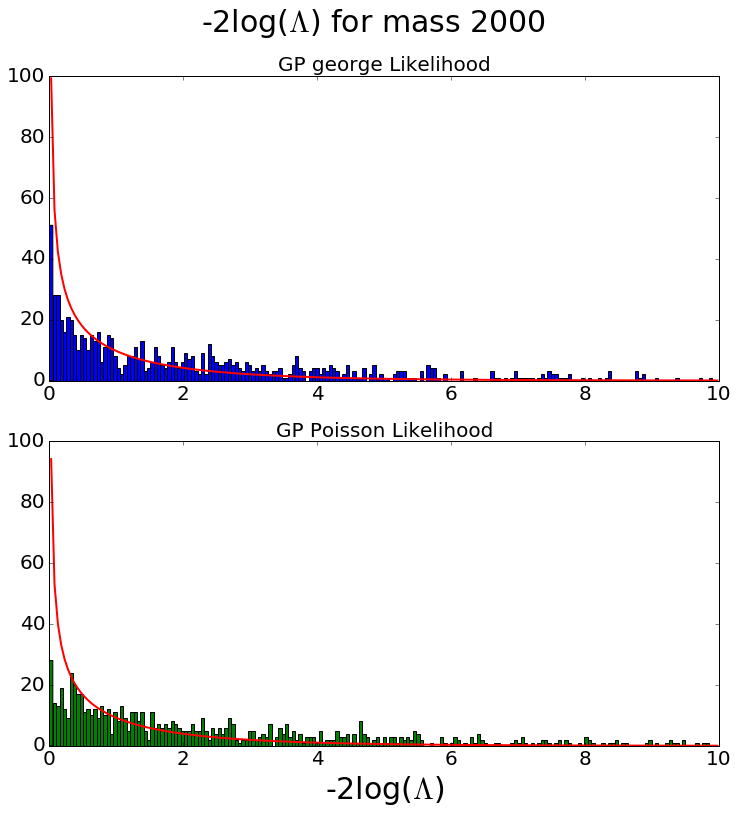

1000
3 parameter poisson, gaussian, poisson with no lngamma % < 0:  0.0
george, poisson % < 0:  0.0 , 0.0
3 parameter poisson, gaussian, poisson with no lngamma % < -1:  0.0
george, poisson % < -1:  0.0 , 0.0


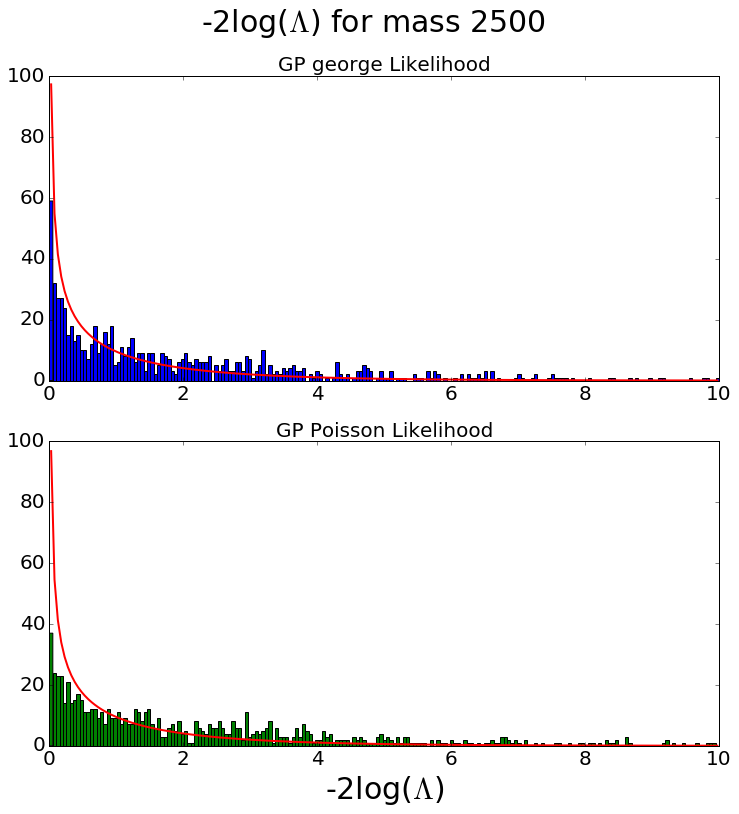

1000
3 parameter poisson, gaussian, poisson with no lngamma % < 0:  0.0
george, poisson % < 0:  0.0 , 0.0
3 parameter poisson, gaussian, poisson with no lngamma % < -1:  0.0
george, poisson % < -1:  0.0 , 0.0


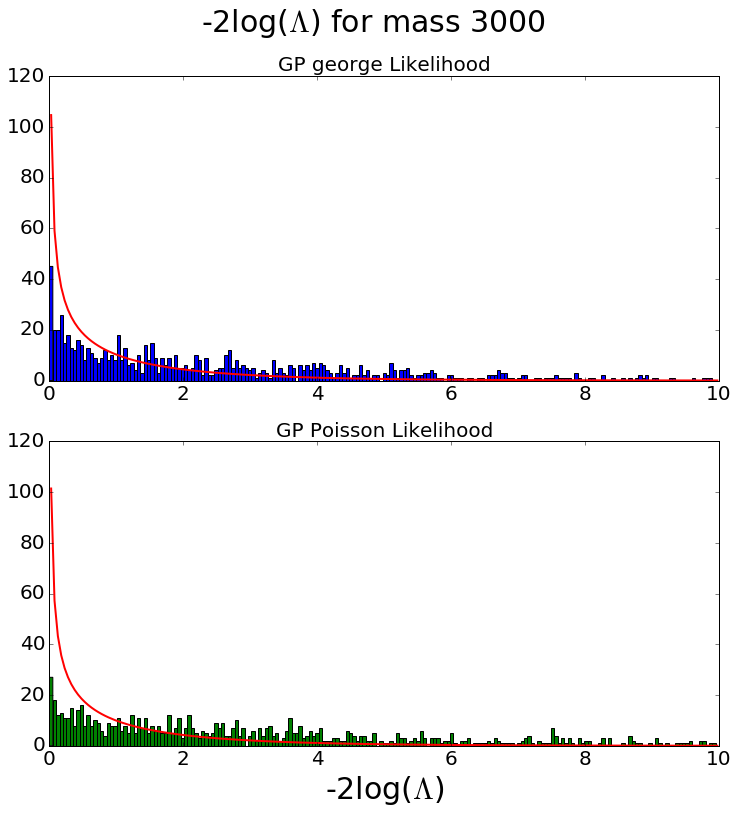

1000
3 parameter poisson, gaussian, poisson with no lngamma % < 0:  0.0
george, poisson % < 0:  0.0 , 0.0
3 parameter poisson, gaussian, poisson with no lngamma % < -1:  0.0
george, poisson % < -1:  0.0 , 0.0


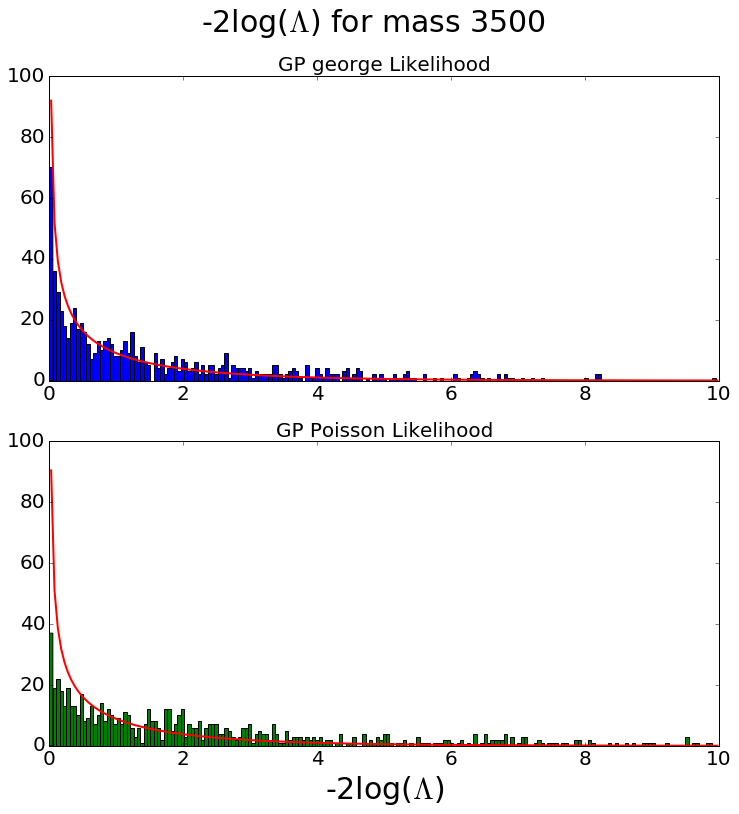

1000
3 parameter poisson, gaussian, poisson with no lngamma % < 0:  0.0
george, poisson % < 0:  0.0 , 0.0
3 parameter poisson, gaussian, poisson with no lngamma % < -1:  0.0
george, poisson % < -1:  0.0 , 0.0


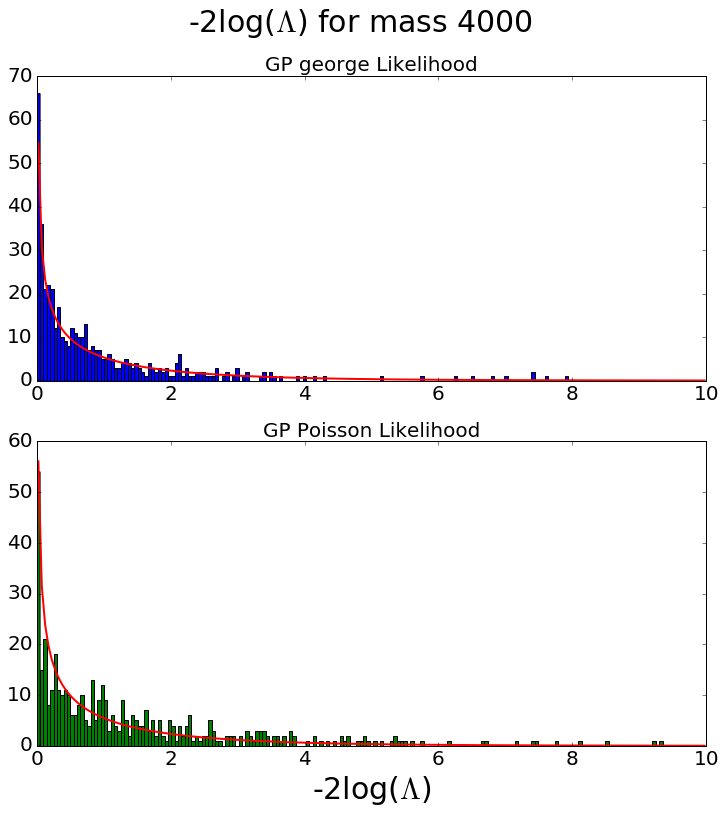

1000
3 parameter poisson, gaussian, poisson with no lngamma % < 0:  0.0
george, poisson % < 0:  0.0 , 0.0
3 parameter poisson, gaussian, poisson with no lngamma % < -1:  0.0
george, poisson % < -1:  0.0 , 0.0


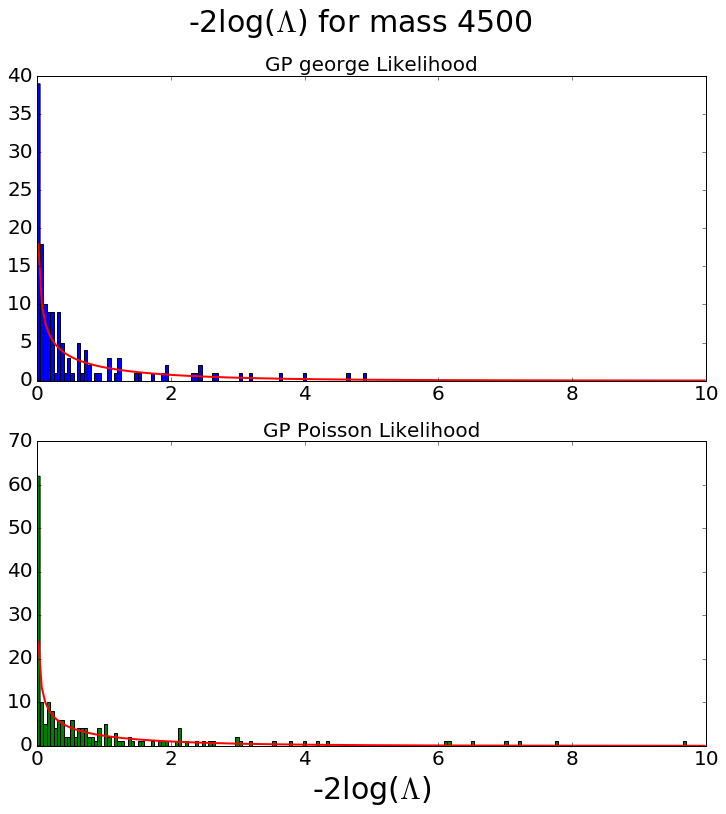

1000
3 parameter poisson, gaussian, poisson with no lngamma % < 0:  0.0
george, poisson % < 0:  0.0 , 0.0
3 parameter poisson, gaussian, poisson with no lngamma % < -1:  0.0
george, poisson % < -1:  0.0 , 0.0


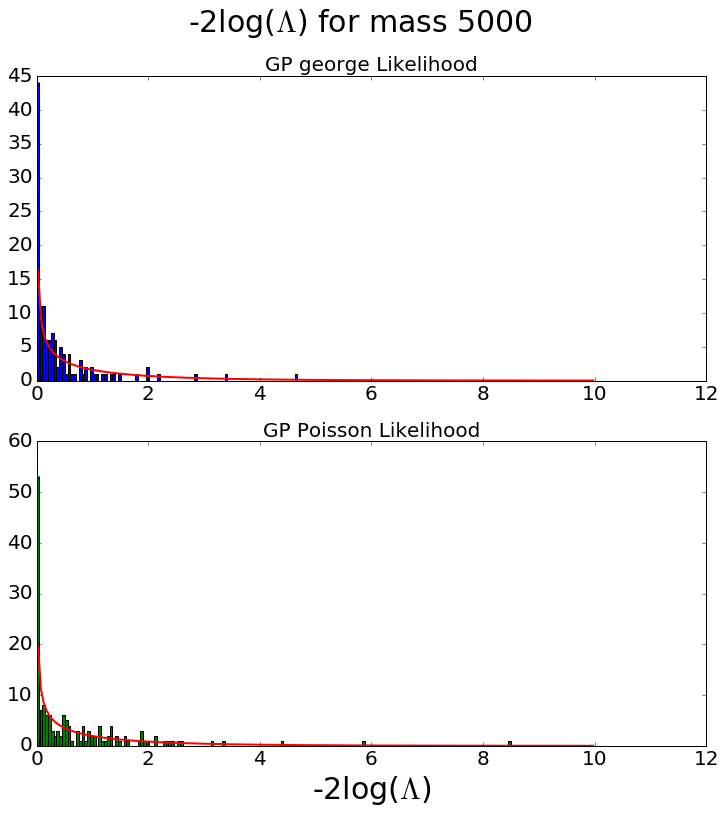

1000
3 parameter poisson, gaussian, poisson with no lngamma % < 0:  0.0
george, poisson % < 0:  0.0 , 0.0
3 parameter poisson, gaussian, poisson with no lngamma % < -1:  0.0
george, poisson % < -1:  0.0 , 0.0


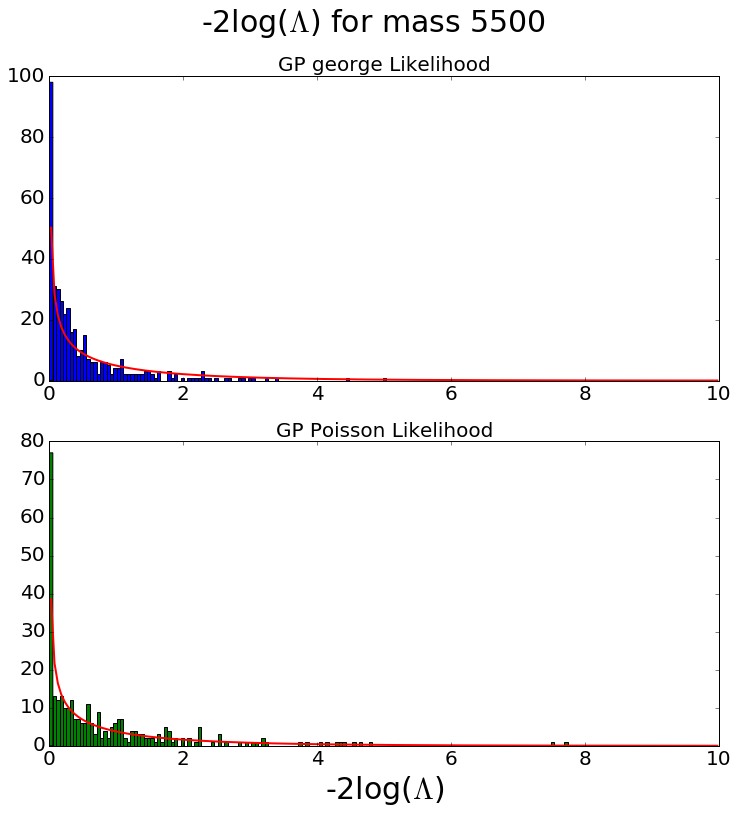

968
3 parameter poisson, gaussian, poisson with no lngamma % < 0:  0.0
george, poisson % < 0:  0.0 , 0.0
3 parameter poisson, gaussian, poisson with no lngamma % < -1:  0.0
george, poisson % < -1:  0.0 , 0.0


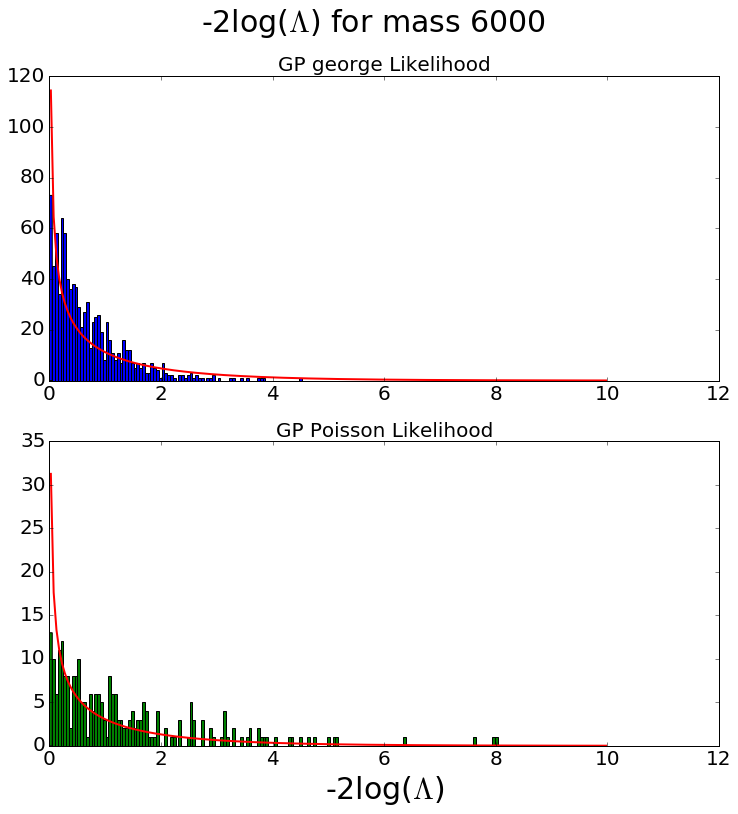

In [60]:
#standardParamSets = [(2000,2000,250), (700, 2500, 250), (250, 3000, 250), (125, 3500, 250), (70, 4000, 250), 
#             (40, 4500, 250), (25, 5000, 250), (15,5500, 250), (10, 6000,250)]
if runOnlyGP: pass
else: 
    msignals = [standardParamSets[i][1] for i in range(len(standardParamSets))]

    FFlist3=[]
    GPlist=[]
    GPlistP=[]
    for m in msignals:
        ff3 = [s for s in np.load("LLHR_3param_"+str(m)+"_noSignal.npy") if not (np.isinf(s) or np.isnan(s) or s < 0.0001)]
        #gp = [s for s in np.load("LLHR_GP_george_"+str(m)+"_noSignal.npy") if not (np.isinf(s) or np.isnan(s) or s < 0.0001)]
        #P = [s for s in np.load("LLHR_GP_Poisson_"+str(m)+"_noSignal.npy") if not (np.isinf(s) or np.isnan(s) or s < 0.0001)]
        print len(LLlistGP[m])
        gp = [s for s in LLlistGP[m] if not (np.isinf(s) or np.isnan(s) or s < 0.0001)] 
        P = [s for s in LLlistGPP[m] if not (np.isinf(s) or np.isnan(s) or s < 0.0001)] 
    
        ff3_neg_frac = round(100.*sum(i < 0 for i in ff3)/len(ff3),2)
        print "3 parameter poisson, gaussian, poisson with no lngamma % < 0: ", ff3_neg_frac
        gp_neg_frac = round(100.*sum(i < 0 for i in gp)/len(gp),2)
        gpP_neg_frac = round(100.*sum(i < 0 for i in P)/len(P),2)
        print "george, poisson % < 0: ", gp_neg_frac, ",", gpP_neg_frac
        
        ff3_neg_frac_non0 = round(100.*sum(i < -1 for i in ff3)/len(ff3),2)
        print "3 parameter poisson, gaussian, poisson with no lngamma % < -1: ", ff3_neg_frac_non0
        gp_neg_frac_non0 = round(100.*sum(i < -1 for i in gp)/len(gp),2)
        gpP_neg_frac_non0 = round(100.*sum(i < -1 for i in P)/len(P),2)
        print "george, poisson % < -1: ", gp_neg_frac_non0, ",",  gpP_neg_frac_non0

        FFlist3.append([np.median(np.array(ff3)), np.std(np.array(ff3)/np.sqrt(len(ff3)))])

        #gp = [s for s in LLlistGP[m] if not (np.isinf(s) or np.isnan(s) or s < 0.001)]
        #P = [s for s in LLlistGPP[m] if not (np.isinf(s) or np.isnan(s) or s < 0.001)]
        GPlist.append([np.median(np.array(gp)), np.std(np.array(gp))/np.sqrt(len(gp))])
        GPlistP.append([np.median(np.array(P)), np.std(np.array(P))/np.sqrt(len(P))])
    
        ff3 = [s for s in ff3 if s > 0]
        #gp = [s for s in gp if s > 0]
        #P = [s for s in P if s > 0]
        label = r"-2log($\Lambda$) for mass "+str(int(m))
        #makePrettyPlots_LLH(ff3, P, label, drawchi2=True, xname =r"-2log($\Lambda$)", label1="3 Param Fit Function", label2 = "GP Poisson Likelihood" )


        label = r"-2log($\Lambda$) for mass "+str(int(m))
        makePrettyPlots_LLH(gp, P, label, drawchi2=True, xname = r"-2log($\Lambda$)", label1 ="GP george Likelihood", label2 = "GP Poisson Likelihood")



In [170]:
def plotBestFitParams(paramList, paramNames,  title):
    f, ax = plt.subplots(1, len(paramList[0]), figsize=(15,5))
    f.suptitle(title, fontsize=20, y = 1.08)
    paramList = [s for s in paramList if not all([True if b == 0 else False for b in s])]
    for iparam in range(len(paramList[0])):
        ax[iparam].set_xlabel(paramNames[iparam], fontsize=15)
        p = [paramList[i][iparam] for i in range(len(paramList))]
        ax[iparam].hist(p, bins=np.linspace(min(p), max(p), 50))
        ax[iparam].axvline(np.mean(p), color='r', linestyle='dashed', linewidth=2)
        ax[iparam].annotate(str(round(np.mean(p),3)), xy=(0.75, 0.75), xycoords='axes fraction')

### Plot average LLH ratio over toys as a function of signal mass

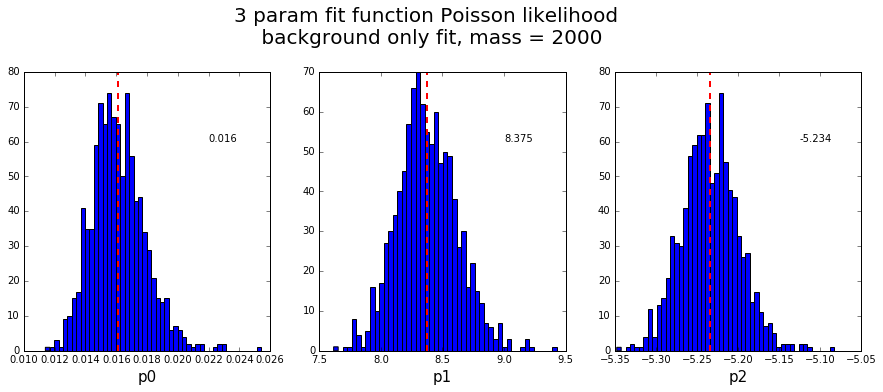

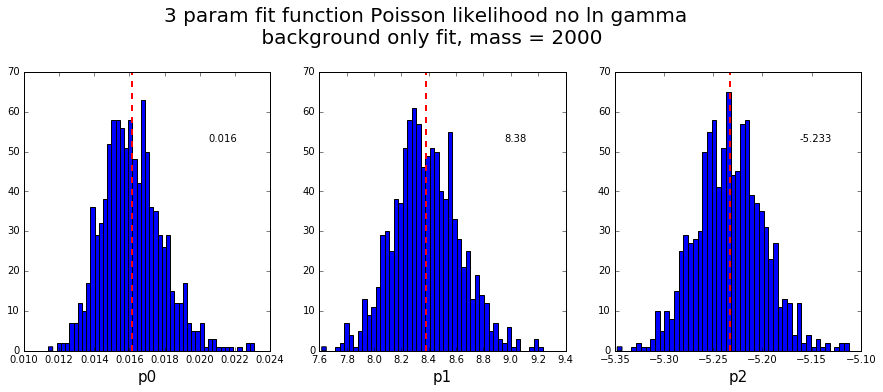

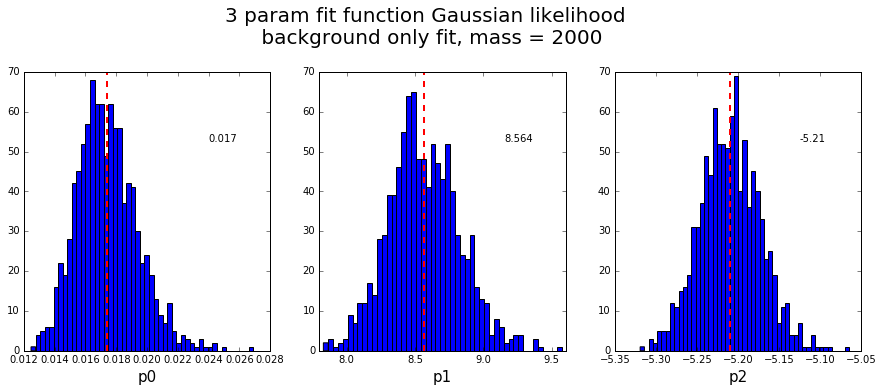

In [171]:
if runOnlyGP: pass
else:
    msignals = [2000]
    for m in msignals:
        plotBestFitParams(paramlistFF3_b[m], ['p0','p1','p2'], "3 param fit function Poisson likelihood \n background only fit, mass = " + str(m))
        plotBestFitParams(paramlistFF3ng_b[m], ['p0','p1','p2'], "3 param fit function Poisson likelihood no ln gamma \n background only fit, mass = " + str(m))
        plotBestFitParams(paramlistFF3G_b[m], ['p0','p1','p2'], "3 param fit function Gaussian likelihood \n background only fit, mass = " + str(m))

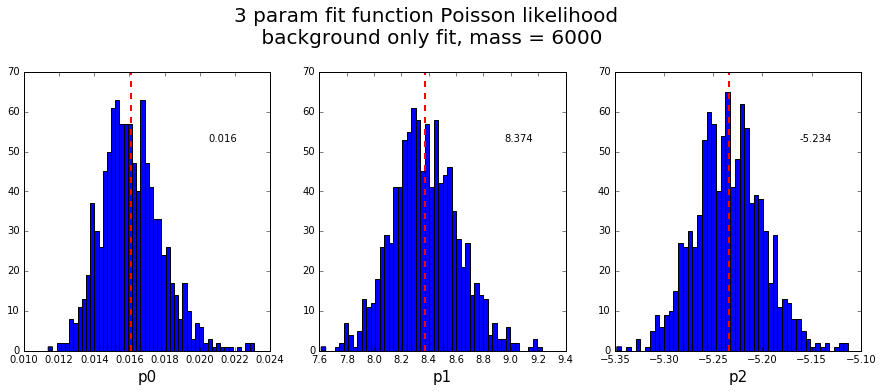

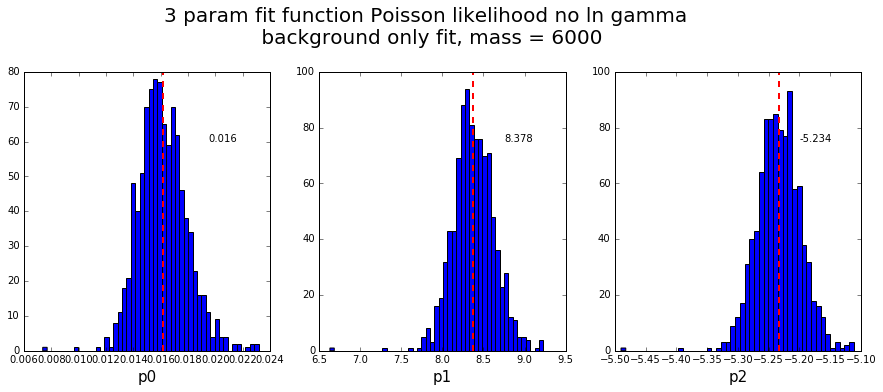

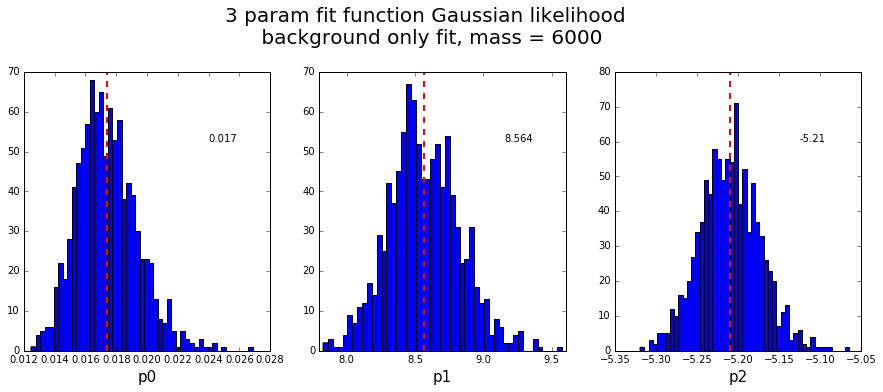

In [172]:
if runOnlyGP: pass
else:
    msignals = [6000]
    for m in msignals:
        plotBestFitParams(paramlistFF3_b[m], ['p0','p1','p2'], "3 param fit function Poisson likelihood \n background only fit, mass = " + str(m))
        plotBestFitParams(paramlistFF3ng_b[m], ['p0','p1','p2'], "3 param fit function Poisson likelihood no ln gamma \n background only fit, mass = " + str(m))
        plotBestFitParams(paramlistFF3G_b[m], ['p0','p1','p2'], "3 param fit function Gaussian likelihood \n background only fit, mass = " + str(m))

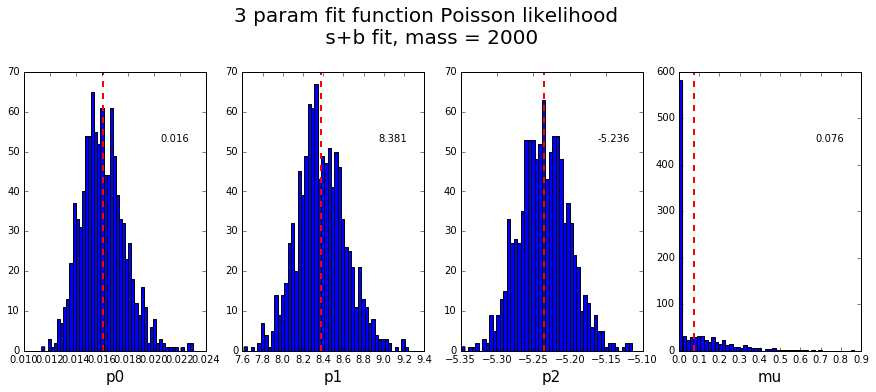

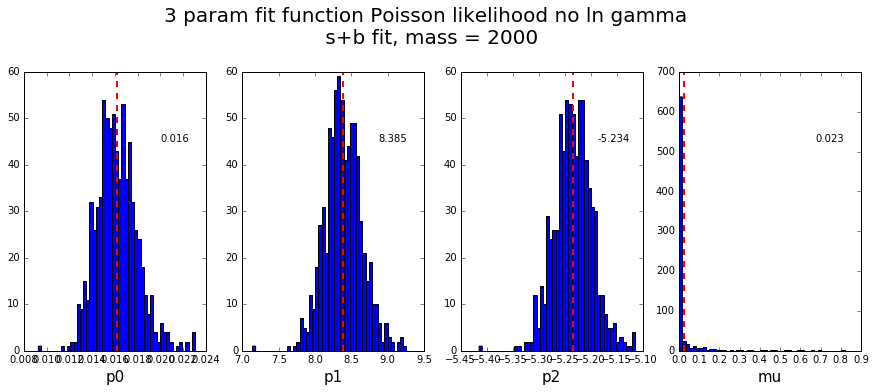

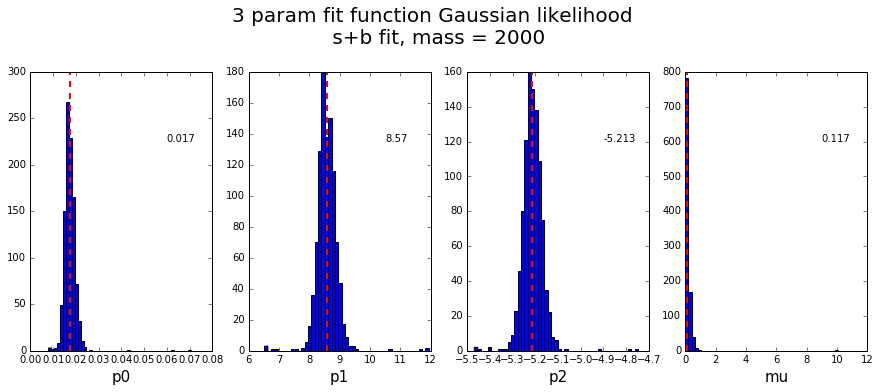

In [173]:
if runOnlyGP: pass
else:
    msignals = [2000]
    for m in msignals:
        plotBestFitParams(paramlistFF3_sb[m], ['p0','p1','p2','mu'], "3 param fit function Poisson likelihood \n s+b fit, mass = " + str(m))
        plotBestFitParams(paramlistFF3ng_sb[m], ['p0','p1','p2','mu'], "3 param fit function Poisson likelihood no ln gamma \n s+b fit, mass = " + str(m))
        plotBestFitParams(paramlistFF3G_sb[m], ['p0','p1','p2','mu'], "3 param fit function Gaussian likelihood \n s+b fit, mass = " + str(m))

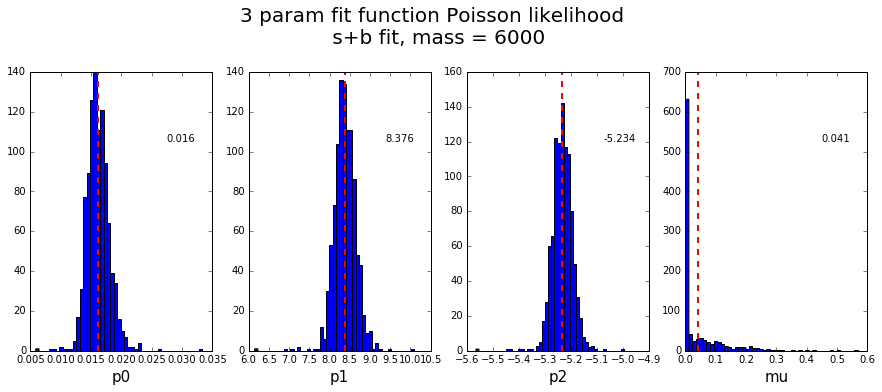

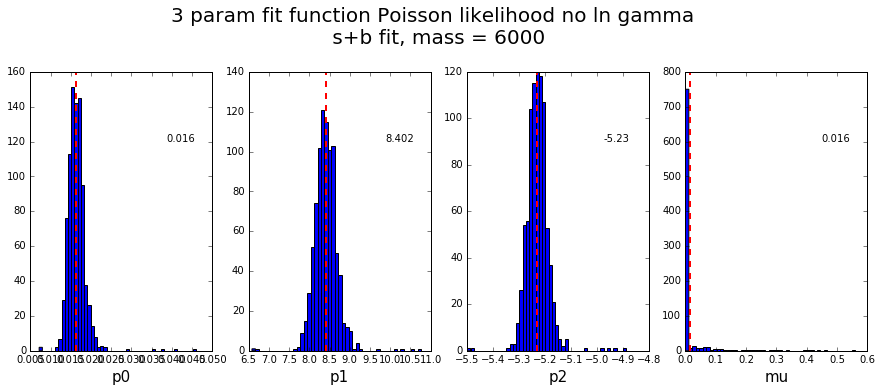

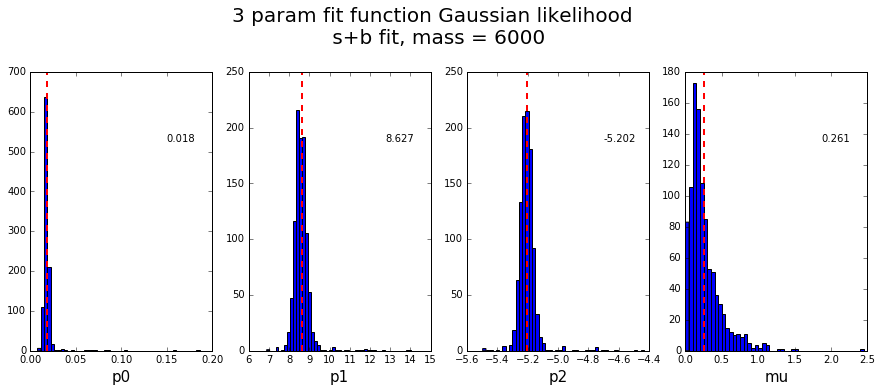

In [174]:
if runOnlyGP: pass
else:
    msignals = [6000]
    for m in msignals:
        plotBestFitParams(paramlistFF3_sb[m], ['p0','p1','p2','mu'], "3 param fit function Poisson likelihood \n s+b fit, mass = " + str(m))
        plotBestFitParams(paramlistFF3ng_sb[m], ['p0','p1','p2','mu'], "3 param fit function Poisson likelihood no ln gamma \n s+b fit, mass = " + str(m))
        plotBestFitParams(paramlistFF3G_sb[m], ['p0','p1','p2','mu'], "3 param fit function Gaussian likelihood \n s+b fit, mass = " + str(m))

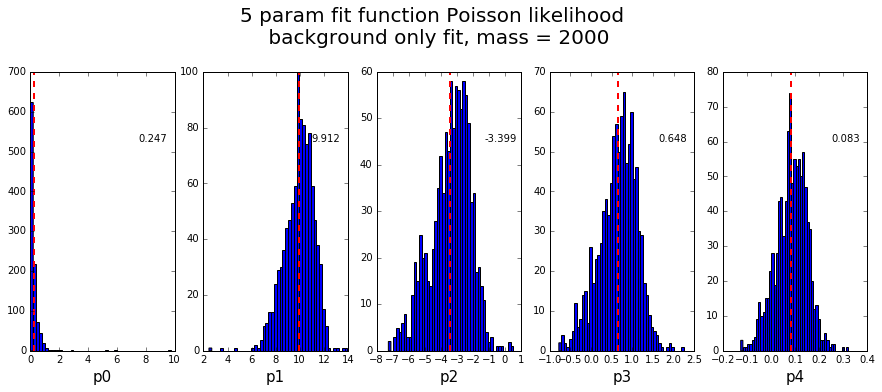

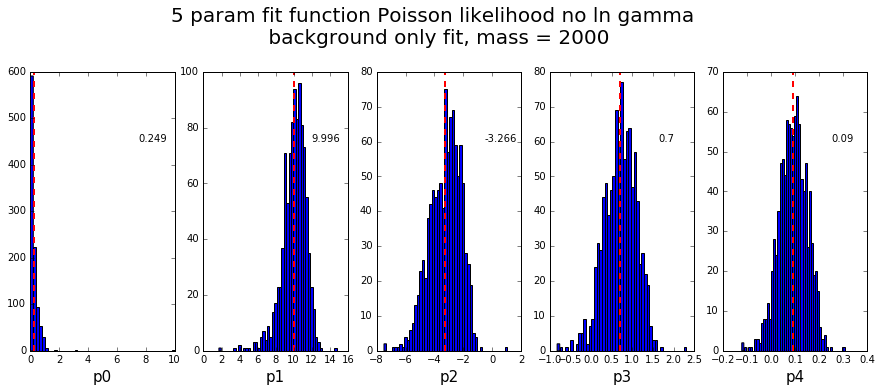

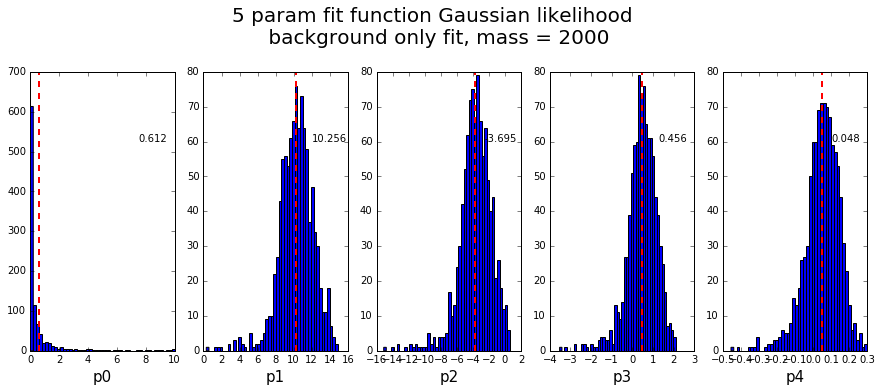

In [175]:
if runOnlyGP: pass
else:
    msignals = [2000]
    for m in msignals:
        plotBestFitParams(paramlistFF5_b[m], ['p0','p1','p2','p3','p4'], "5 param fit function Poisson likelihood \n background only fit, mass = " + str(m))
        plotBestFitParams(paramlistFF5ng_b[m], ['p0','p1','p2','p3','p4'], "5 param fit function Poisson likelihood no ln gamma \n background only fit, mass = " + str(m))
        plotBestFitParams(paramlistFF5G_b[m], ['p0','p1','p2','p3','p4'], "5 param fit function Gaussian likelihood \n background only fit, mass = " + str(m))

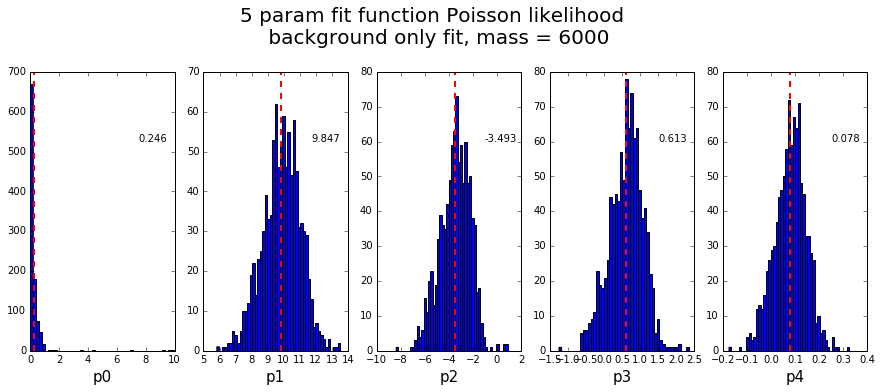

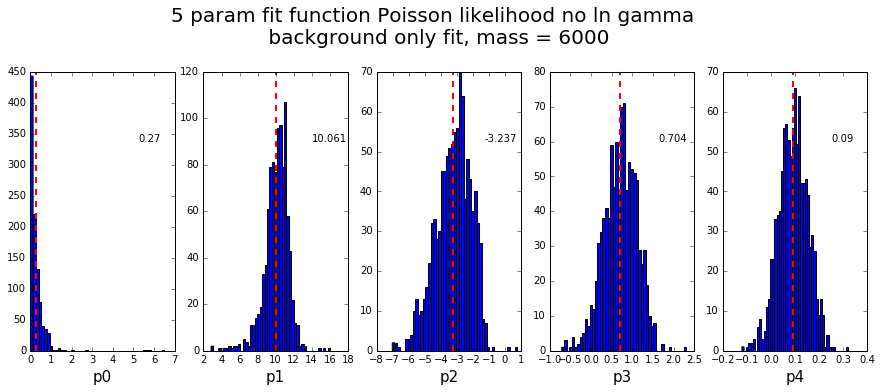

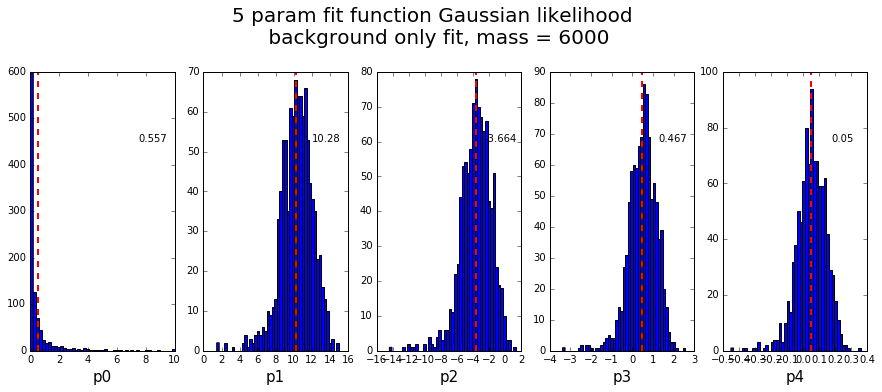

In [176]:
if runOnlyGP: pass
else:
    msignals = [6000]
    for m in msignals:
        plotBestFitParams(paramlistFF5_b[m], ['p0','p1','p2','p3','p4'], "5 param fit function Poisson likelihood \n background only fit, mass = " + str(m))
        plotBestFitParams(paramlistFF5ng_b[m], ['p0','p1','p2','p3','p4'], "5 param fit function Poisson likelihood no ln gamma \n background only fit, mass = " + str(m))
        plotBestFitParams(paramlistFF5G_b[m], ['p0','p1','p2','p3','p4'], "5 param fit function Gaussian likelihood \n background only fit, mass = " + str(m))

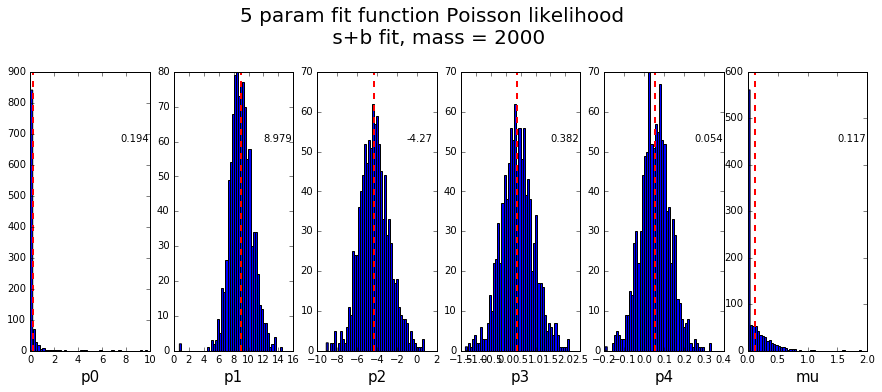

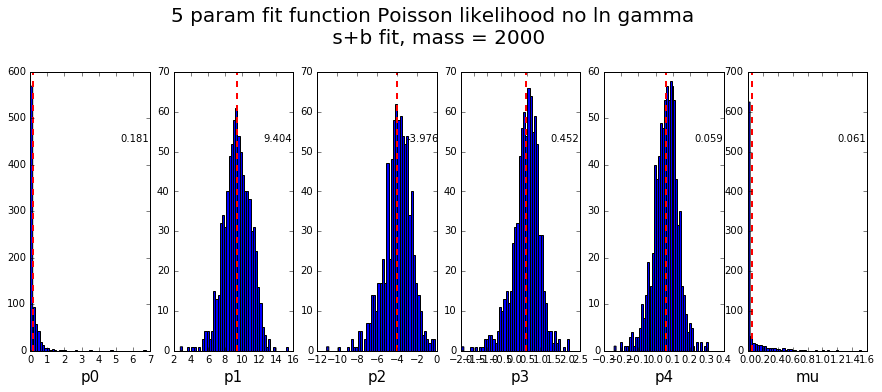

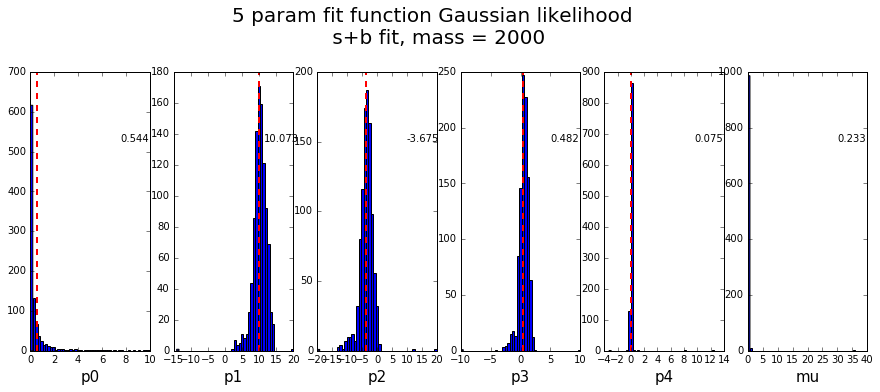

In [177]:
if runOnlyGP: pass
else:
    msignals = [2000]
    for m in msignals:
        plotBestFitParams(paramlistFF5_sb[m], ['p0','p1','p2','p3','p4','mu'], "5 param fit function Poisson likelihood \n s+b fit, mass = " + str(m))
        plotBestFitParams(paramlistFF5ng_sb[m], ['p0','p1','p2','p3','p4','mu'], "5 param fit function Poisson likelihood no ln gamma \n s+b fit, mass = " + str(m))
        plotBestFitParams(paramlistFF5G_sb[m], ['p0','p1','p2','p3','p4','mu'], "5 param fit function Gaussian likelihood \n s+b fit, mass = " + str(m))

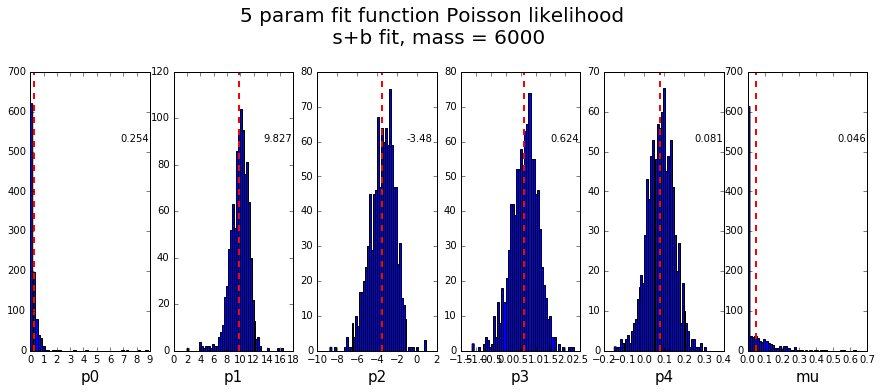

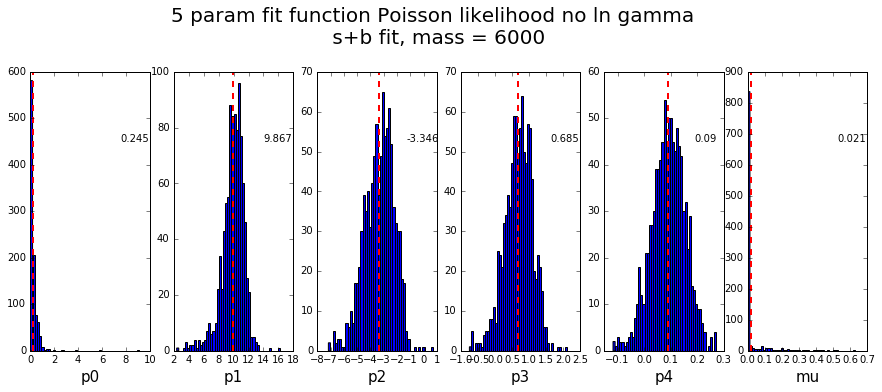

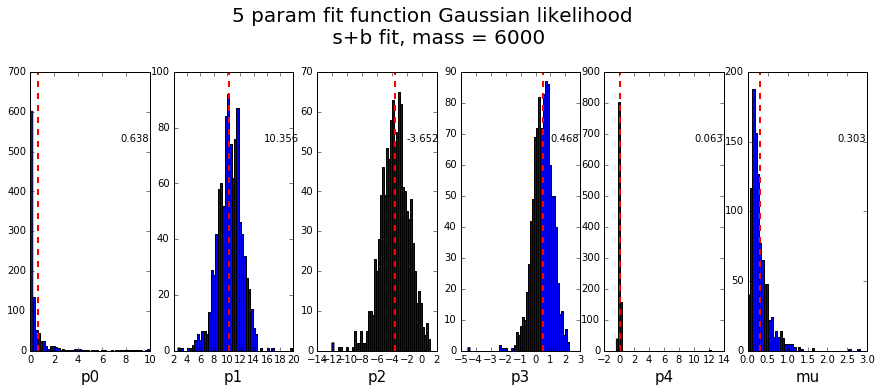

In [178]:
if runOnlyGP: pass
else:
    msignals = [6000]
    for m in msignals:
        plotBestFitParams(paramlistFF5_sb[m], ['p0','p1','p2','p3','p4','mu'], "5 param fit function Poisson likelihood \n s+b fit, mass = " + str(m))
        plotBestFitParams(paramlistFF5ng_sb[m], ['p0','p1','p2','p3','p4','mu'], "5 param fit function Poisson likelihood no ln gamma \n s+b fit, mass = " + str(m))
        plotBestFitParams(paramlistFF5G_sb[m], ['p0','p1','p2','p3','p4','mu'], "5 param fit function Gaussian likelihood \n s+b fit, mass = " + str(m))

In [74]:
#GPlist.insert(1, GPlistb[0])
#GPlistP.insert(1, GPPlistb[0])
#FFlist3.insert(1, FFlist3b[0])

[5.165077067204038e-05, 0.0066095004166299987, 4.0356490103476972e-05]
[0.00034767934351975782, -6.5864469434018247e-10, 0.56137661914021919]
[2.6162172162003117e-07, 1.3447845503833378e-07, -1.4429608667566072]


(1e-10, 2500)

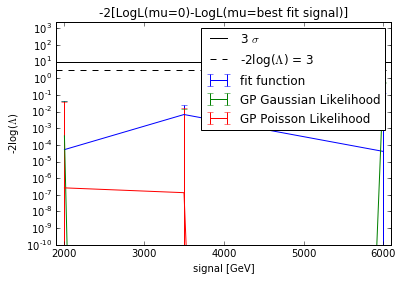

In [77]:
if runOnlyGP or runOnlyFF: pass
else:
    msignals = [2000, 3500, 6000]
    print [FFlist3[i][0] for i in range(len(msignals))]
    print [GPlist[i][0] for i in range(len(msignals))]
    print [GPlistP[i][0] for i in range(len(msignals))]
    plt.figure()
    plt.errorbar(msignals, [FFlist3[i][0] for i in range(len(msignals))] , yerr = [FFlist3[i][1] for i in range(len(msignals))], color="b", label="fit function")
    plt.errorbar(msignals, [GPlist[i][0] for i in range(len(msignals))], yerr = [GPlist[i][1] for i in range(len(msignals))], color="g", label="GP Gaussian Likelihood")
    plt.errorbar(msignals, [GPlistP[i][0] for i in range(len(msignals))], yerr = [GPlistP[i][1] for i in range(len(msignals))], color="r", label="GP Poisson Likelihood")
    plt.plot([1900,6100], 10*np.ones(2), c='black', label=r'3 $\sigma$')
    plt.plot([1900,6100], 3*np.ones(2), c='black', ls='--', label=r"-2log($\Lambda$) = 3")

    plt.xlabel("signal [GeV]")
    plt.yscale('log', nonposy="clip")
    plt.xlim([1900, 6100])
    plt.title("-2[LogL(mu=0)-LogL(mu=best fit signal)]")
    plt.ylabel(r"-2log($\Lambda$)")
    plt.legend(loc=1)
    plt.ylim([1e-10, 2500])